In [1]:
import matplotlib.pyplot as plt
import os
from os.path import join
import numpy as np
from PIL import Image
import matplotlib.image as mpimg
from skimage.color import rgb2gray
from skimage.color import label2rgb
from skimage.filters import gaussian
from sklearn.cluster import KMeans


In [2]:
plt.close('all')
clear = lambda: os.system('clear')
clear()

1

In [3]:
current_directory = os.getcwd()

output_dest = join(current_directory, "Output")
input_dest =join(current_directory, "Input")

In [10]:
np.random.seed(110)
imgNames=['water_coins','jump','tiger']
segmentCounts = np.asarray([2,3,4,5])
for imgName in imgNames:
  for SegCount in segmentCounts:
    image_location = join(''.join([input_dest, '/', imgName, '.png']))
    img=mpimg.imread(image_location)
    print('Using Matplotlib Image Library: Image is of datatype ',img.dtype,'and size ',img.shape)
    img=Image.open(image_location)
    
    #img=np.array(img)

    #print('Using Pillow (Python Image Library): Image is of datatype ',img.dtype,'and size ',img.shape)
    nSegments=SegCount
    width,height=img.size
    nPixels=width*height
    img=np.array(img)
    #print(npixels)
    maxIterations=20;
    nColors=img.shape[2];
    
    outputPath=join(''.join([output_dest,'/',str(SegCount), '_segments/',imgName , '/']));
    print('Output Path : {}'.format(outputPath))
    if not(os.path.exists(outputPath)):
      os.makedirs(outputPath)
    
    if not os.path.exists(outputPath + '0.png'):
      mpimg.imsave(outputPath + '0.png', img)

            
    
    pixels=img
    #print(img.shape)
    pixels = np.reshape(pixels, (nPixels, nColors, 1))


    pi = (1/nSegments) * (np.ones((nSegments, 1),dtype='float'))
    increment = np.random.normal(0,.0001,1)
    for seg_ctr in range(len(pi)):
      if(seg_ctr%2==1):
        pi[seg_ctr] = pi[seg_ctr] + increment
      else:
        pi[seg_ctr] = pi[seg_ctr] - increment
    
    mu = (1 / nSegments)*(np.ones((nSegments, nColors), dtype='float'))
    #length=len(pi)
    for seg_ctr in range(nSegments):
      if(seg_ctr%2==1):
        increment = np.random.normal(0,.0001,1)
      for col_ctr in range(nColors):
        if(seg_ctr%2==1):
          mu[seg_ctr,col_ctr] = np.mean(pixels[:,col_ctr]) + increment
        else:
          mu[seg_ctr,col_ctr] = np.mean(pixels[:,col_ctr]) - increment
    
    mu_last_iter = mu;
    pi_last_iter = pi;

    for iteration in range(maxIterations):
      print(''.join(['Image: ',imgName,' nSegments: ',str(nSegments),'iteration: ',str(iteration+1), ' E-step']))
      Ws = np.ones((nPixels,nSegments),dtype='float')
      for pix_ctr in range(nPixels):
        logAjVec = np.zeros((nSegments,1),dtype='float')
        for seg_ctr in range(nSegments):
          x_minus_mu_T = np.transpose(pixels[pix_ctr,:]-(mu[seg_ctr,:])[np.newaxis].T)
          x_minus_mu = ((pixels[pix_ctr,:]-(mu[seg_ctr,:])[np.newaxis].T))
          logAjVec[seg_ctr] = np.log(pi[seg_ctr]) - .5*(np.dot(x_minus_mu_T,x_minus_mu))
        
        logAmax = max(logAjVec.tolist())

        thirdTerm = 0;
        for seg_ctr in range(nSegments):
          thirdTerm = thirdTerm + np.exp(logAjVec[seg_ctr]-logAmax)
        
        for seg_ctr in range(nSegments):
          logY =logAjVec[seg_ctr] - logAmax - np.log(thirdTerm)
          Ws[pix_ctr][seg_ctr] = np.exp(logY)
      


      #M-STEP#
      print(''.join(['Image: ',imgName,' nSegments: ',str(nSegments),'iteration: ',str(iteration+1), ' M-step: Mixture coefficients']))

      mu=np.zeros((nSegments,nColors),dtype='float') 
      pi=np.zeros((nSegments,1),dtype='float')


      for seg_ctr in range(nSegments):
        denominatorSum = 0;
        #for  pix_ctr in range(nPixels):
         # mu[seg_ctr] = mu[seg_ctr] + np.squeeze(pixels[pix_ctr,:])*Ws[pix_ctr, seg_ctr]
          #denominatorSum = denominatorSum + Ws[pix_ctr][seg_ctr]


        mu[seg_ctr] =  np.reshape(np.dot(np.transpose(np.squeeze(pixels)), Ws[:, seg_ctr]), (nColors, ))
        denominatorSum = denominatorSum + np.sum(Ws[:, seg_ctr])
        mu[seg_ctr,:] =  mu[seg_ctr,:]/ denominatorSum; 
        pi[seg_ctr] = denominatorSum / nPixels;

      print(np.transpose(pi))

      muDiffSq = np.sum(np.multiply((mu - mu_last_iter),(mu - mu_last_iter)))
      piDiffSq = np.sum(np.multiply((pi - pi_last_iter),(pi - pi_last_iter)))

      if (muDiffSq < .0000001 and piDiffSq < .0000001):#sign of convergence
        print('Convergence Criteria Met at Iteration: ',iteration, '-- Exiting code') 
        break;

      mu_last_iter=mu;
      pi_last_iter=pi;
      segpixels = np.array(pixels)
      cluster=0

      for pix_ctr in range(nPixels):
        cluster=np.where(Ws[pix_ctr,:] == max(Ws[pix_ctr,:]))
        vec = np.squeeze(np.transpose(mu[cluster,:]))
        segpixels[pix_ctr,:] =  vec.reshape(vec.shape[0],1)
      
      
      
      my_colors = [[1,0,0],[0,1,0],[0,0,1],[0,0.5,0.5],[0.5,0,0.5]]
      segpixels = np.reshape(segpixels,(img.shape[0],img.shape[1],nColors)) ## reshape segpixels to obtain R,G, B image
      segpixels = rgb2gray(segpixels.astype('uint8')) # convert to grayscale
      kmeans = KMeans(n_clusters=SegCount).fit(np.reshape(segpixels, (segpixels.shape[0] * segpixels.shape[1], 1)))
      seglabels = np.reshape(kmeans.labels_, (segpixels.shape[0], segpixels.shape[1]))
      seglabels = gaussian(np.clip(label2rgb(seglabels, colors=my_colors ), a_min = 0, a_max = 1), sigma = 2, multichannel=False)
      mpimg.imsave(''.join([outputPath,str(iteration+1),'.png']),seglabels) #save the segmented outputsys.exit()

Using Matplotlib Image Library: Image is of datatype  float32 and size  (312, 252, 3)
Output Path : C:\Users\hp\Output/2_segments/water_coins/
Image: water_coins nSegments: 2iteration: 1 E-step
Image: water_coins nSegments: 2iteration: 1 M-step: Mixture coefficients
[[0.49996714 0.50003286]]
Image: water_coins nSegments: 2iteration: 2 E-step
Image: water_coins nSegments: 2iteration: 2 M-step: Mixture coefficients
[[0.44622235 0.55377765]]
Image: water_coins nSegments: 2iteration: 3 E-step
Image: water_coins nSegments: 2iteration: 3 M-step: Mixture coefficients
[[0.44233313 0.55766687]]
Image: water_coins nSegments: 2iteration: 4 E-step
Image: water_coins nSegments: 2iteration: 4 M-step: Mixture coefficients
[[0.4420263 0.5579737]]
Image: water_coins nSegments: 2iteration: 5 E-step
Image: water_coins nSegments: 2iteration: 5 M-step: Mixture coefficients
[[0.4419647 0.5580353]]
Image: water_coins nSegments: 2iteration: 6 E-step
Image: water_coins nSegments: 2iteration: 6 M-step: Mixture 

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)


Image: water_coins nSegments: 3iteration: 2 E-step
Image: water_coins nSegments: 3iteration: 2 M-step: Mixture coefficients
[[0.00119731 0.44569995 0.55310274]]
Image: water_coins nSegments: 3iteration: 3 E-step
Image: water_coins nSegments: 3iteration: 3 M-step: Mixture coefficients
[[0.04250423 0.42040175 0.53709402]]
Image: water_coins nSegments: 3iteration: 4 E-step
Image: water_coins nSegments: 3iteration: 4 M-step: Mixture coefficients
[[0.04630196 0.41498179 0.53871626]]
Image: water_coins nSegments: 3iteration: 5 E-step
Image: water_coins nSegments: 3iteration: 5 M-step: Mixture coefficients
[[0.0474237  0.4123865  0.54018979]]
Image: water_coins nSegments: 3iteration: 6 E-step
Image: water_coins nSegments: 3iteration: 6 M-step: Mixture coefficients
[[0.04821937 0.41063214 0.54114849]]
Image: water_coins nSegments: 3iteration: 7 E-step
Image: water_coins nSegments: 3iteration: 7 M-step: Mixture coefficients
[[0.04906744 0.40940582 0.54152675]]
Image: water_coins nSegments: 3ite

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)


Image: water_coins nSegments: 5iteration: 2 E-step
Image: water_coins nSegments: 5iteration: 2 M-step: Mixture coefficients
[[5.10832074e-04 4.45624996e-01 5.52927544e-01 4.82488821e-04
  4.54139163e-04]]


C:\Users\hp\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)


Image: water_coins nSegments: 5iteration: 3 E-step
Image: water_coins nSegments: 5iteration: 3 M-step: Mixture coefficients
[[0.01580788 0.41984636 0.53682151 0.00118878 0.02633547]]
Image: water_coins nSegments: 5iteration: 4 E-step
Image: water_coins nSegments: 5iteration: 4 M-step: Mixture coefficients
[[0.01708504 0.40712758 0.53141385 0.0103003  0.03407324]]
Image: water_coins nSegments: 5iteration: 5 E-step
Image: water_coins nSegments: 5iteration: 5 M-step: Mixture coefficients
[[0.02048245 0.39861219 0.52633444 0.01625238 0.03831854]]
Image: water_coins nSegments: 5iteration: 6 E-step
Image: water_coins nSegments: 5iteration: 6 M-step: Mixture coefficients
[[0.02532487 0.39247312 0.52087366 0.02014658 0.04118178]]
Image: water_coins nSegments: 5iteration: 7 E-step
Image: water_coins nSegments: 5iteration: 7 M-step: Mixture coefficients
[[0.03091045 0.3869266  0.51490175 0.02248045 0.04478075]]
Image: water_coins nSegments: 5iteration: 8 E-step
Image: water_coins nSegments: 5ite

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return_n_iter=True)


Image: jump nSegments: 4iteration: 2 E-step
Image: jump nSegments: 4iteration: 2 M-step: Mixture coefficients
[[0.00452529 0.36762143 0.62332456 0.00452873]]


C:\Users\hp\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return_n_iter=True)


Image: jump nSegments: 4iteration: 3 E-step
Image: jump nSegments: 4iteration: 3 M-step: Mixture coefficients
[[0.0862729  0.21859387 0.51872145 0.17641178]]
Image: jump nSegments: 4iteration: 4 E-step
Image: jump nSegments: 4iteration: 4 M-step: Mixture coefficients
[[0.1382848  0.17484623 0.46744518 0.21942379]]
Image: jump nSegments: 4iteration: 5 E-step
Image: jump nSegments: 4iteration: 5 M-step: Mixture coefficients
[[0.14106002 0.17220434 0.42770705 0.25902858]]
Image: jump nSegments: 4iteration: 6 E-step
Image: jump nSegments: 4iteration: 6 M-step: Mixture coefficients
[[0.14625828 0.17202514 0.39722032 0.28449625]]
Image: jump nSegments: 4iteration: 7 E-step
Image: jump nSegments: 4iteration: 7 M-step: Mixture coefficients
[[0.15320872 0.17206113 0.38306625 0.2916639 ]]
Image: jump nSegments: 4iteration: 8 E-step
Image: jump nSegments: 4iteration: 8 M-step: Mixture coefficients
[[0.15963533 0.17213295 0.37559451 0.29263721]]
Image: jump nSegments: 4iteration: 9 E-step
Image: j

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)


Image: jump nSegments: 5iteration: 2 E-step
Image: jump nSegments: 5iteration: 2 M-step: Mixture coefficients
[[0.00513388 0.36417622 0.61917981 0.00499579 0.0065143 ]]


C:\Users\hp\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)


Image: jump nSegments: 5iteration: 3 E-step
Image: jump nSegments: 5iteration: 3 M-step: Mixture coefficients
[[0.10530097 0.21724356 0.51467063 0.01447716 0.14830768]]
Image: jump nSegments: 5iteration: 4 E-step
Image: jump nSegments: 5iteration: 4 M-step: Mixture coefficients
[[0.14386418 0.17367449 0.41808199 0.05756961 0.20680973]]
Image: jump nSegments: 5iteration: 5 E-step
Image: jump nSegments: 5iteration: 5 M-step: Mixture coefficients
[[0.15038573 0.17260319 0.37183976 0.06014603 0.24502529]]
Image: jump nSegments: 5iteration: 6 E-step
Image: jump nSegments: 5iteration: 6 M-step: Mixture coefficients
[[0.16025388 0.17262278 0.34788938 0.06075524 0.25847873]]
Image: jump nSegments: 5iteration: 7 E-step
Image: jump nSegments: 5iteration: 7 M-step: Mixture coefficients
[[0.16952062 0.1727403  0.33588539 0.06082843 0.26102527]]
Image: jump nSegments: 5iteration: 8 E-step
Image: jump nSegments: 5iteration: 8 M-step: Mixture coefficients
[[0.17674902 0.17277952 0.3255047  0.06067198

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)


Image: tiger nSegments: 3iteration: 2 E-step
Image: tiger nSegments: 3iteration: 2 M-step: Mixture coefficients
[[0.0103453  0.61820347 0.37145124]]
Image: tiger nSegments: 3iteration: 3 E-step
Image: tiger nSegments: 3iteration: 3 M-step: Mixture coefficients
[[0.28702984 0.47137664 0.24159352]]
Image: tiger nSegments: 3iteration: 4 E-step
Image: tiger nSegments: 3iteration: 4 M-step: Mixture coefficients
[[0.35968113 0.43534746 0.20497141]]
Image: tiger nSegments: 3iteration: 5 E-step
Image: tiger nSegments: 3iteration: 5 M-step: Mixture coefficients
[[0.37442039 0.43270599 0.19287362]]
Image: tiger nSegments: 3iteration: 6 E-step
Image: tiger nSegments: 3iteration: 6 M-step: Mixture coefficients
[[0.37466689 0.43730468 0.18802843]]
Image: tiger nSegments: 3iteration: 7 E-step
Image: tiger nSegments: 3iteration: 7 M-step: Mixture coefficients
[[0.37192632 0.44249774 0.18557593]]
Image: tiger nSegments: 3iteration: 8 E-step
Image: tiger nSegments: 3iteration: 8 M-step: Mixture coeffic

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return_n_iter=True)


Image: tiger nSegments: 4iteration: 2 E-step
Image: tiger nSegments: 4iteration: 2 M-step: Mixture coefficients
[[0.01440464 0.36791719 0.60670049 0.01097768]]
Image: tiger nSegments: 4iteration: 3 E-step
Image: tiger nSegments: 4iteration: 3 M-step: Mixture coefficients
[[0.15462114 0.24167011 0.45693894 0.1467698 ]]
Image: tiger nSegments: 4iteration: 4 E-step
Image: tiger nSegments: 4iteration: 4 M-step: Mixture coefficients
[[0.2484054  0.1923689  0.37434101 0.18488469]]
Image: tiger nSegments: 4iteration: 5 E-step
Image: tiger nSegments: 4iteration: 5 M-step: Mixture coefficients
[[0.30962265 0.17044593 0.32742292 0.1925085 ]]
Image: tiger nSegments: 4iteration: 6 E-step
Image: tiger nSegments: 4iteration: 6 M-step: Mixture coefficients
[[0.35003303 0.15902621 0.29874121 0.19219955]]
Image: tiger nSegments: 4iteration: 7 E-step
Image: tiger nSegments: 4iteration: 7 M-step: Mixture coefficients
[[0.37540109 0.15263852 0.28200264 0.18995775]]
Image: tiger nSegments: 4iteration: 8 E-

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)


Image: tiger nSegments: 5iteration: 2 E-step
Image: tiger nSegments: 5iteration: 2 M-step: Mixture coefficients
[[0.00785695 0.00773622 0.00782183 0.36612204 0.61046297]]
Image: tiger nSegments: 5iteration: 3 E-step
Image: tiger nSegments: 5iteration: 3 M-step: Mixture coefficients
[[0.08818696 0.13901936 0.07178315 0.23802683 0.4629837 ]]
Image: tiger nSegments: 5iteration: 4 E-step
Image: tiger nSegments: 5iteration: 4 M-step: Mixture coefficients
[[0.14471862 0.17761673 0.1080569  0.18984149 0.37976625]]
Image: tiger nSegments: 5iteration: 5 E-step
Image: tiger nSegments: 5iteration: 5 M-step: Mixture coefficients
[[0.18984476 0.17085345 0.1641872  0.16810586 0.30700873]]
Image: tiger nSegments: 5iteration: 6 E-step
Image: tiger nSegments: 5iteration: 6 M-step: Mixture coefficients
[[0.19873714 0.1652687  0.21562313 0.15523648 0.26513456]]
Image: tiger nSegments: 5iteration: 7 E-step
Image: tiger nSegments: 5iteration: 7 M-step: Mixture coefficients
[[0.20101933 0.16099761 0.2558986

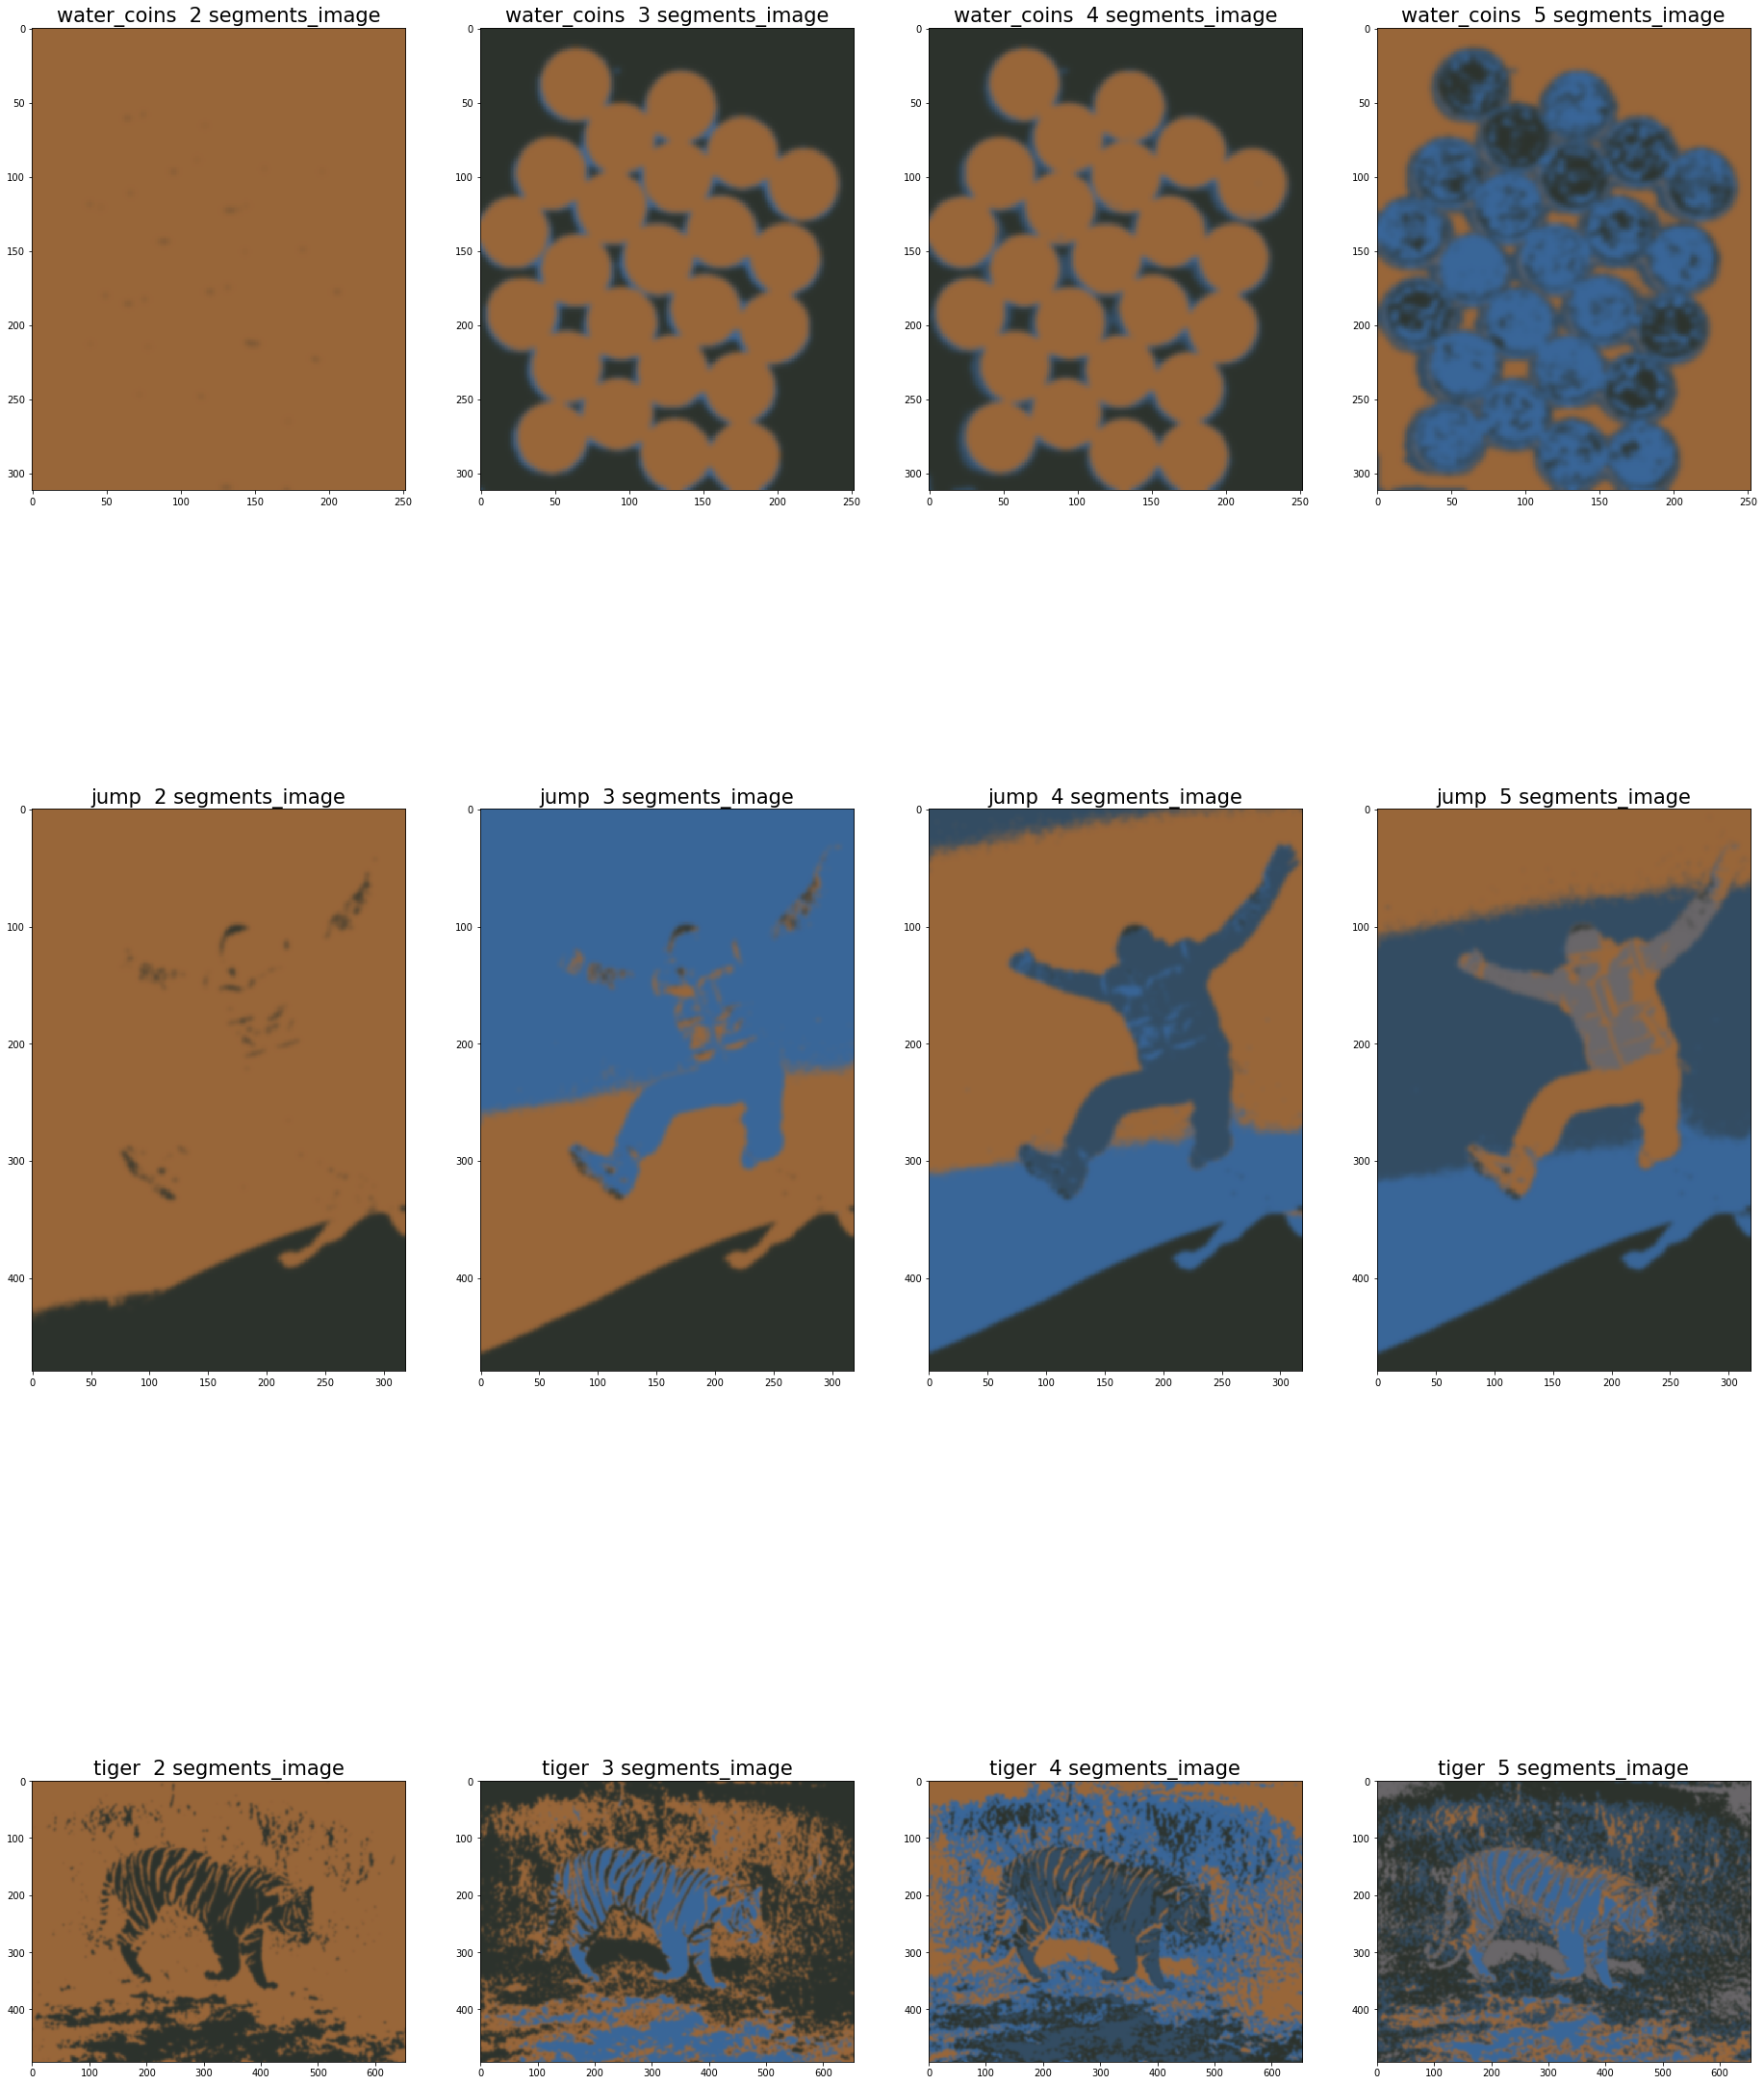

In [16]:
# --- DISPLAY FINAL SEGMENTED IMAGE --- #

fig = plt.figure(figsize = (32, 45))

# plot number
i = 0

# display final segmented image
for imgName in imgNames :
    for SegCount in segmentCounts :
        
        # get output path
        outputPath = join(''.join(['Output/',str(SegCount), '_segments/', imgName , '/']))
        
        # get all the files in the image
        all_files = os.listdir(outputPath)
        
        # get number of images
        number_images = []
        
        # append all the iteration image
        for a_file in all_files:
            a_file = int(a_file[:-4])
            number_images.append(a_file)
        
        number_images.sort()
        
        # get the last image
        get_last_image_iteration = number_images[-1]
        
        # read the image
        img = mpimg.imread(outputPath + str(get_last_image_iteration) + '.png')
        
        # add to subplot
        im = fig.add_subplot(3, 4, i+1)
        i = i + 1
        
        # set title of image
        im.set_title(imgName + "  " + str(SegCount) + " segments_image", fontsize=21)
        
        plt.imshow(img)
        
plt.show()